# 0. Load Data

In [ ]:
from geoband.API import *

# API 데이터 다운로드
GetCompasData('SBJ_2012_001', '1', '1.오산시_주정차단속(2018~2020).csv')
GetCompasData('SBJ_2012_001', '2', '2.오산시_어린이교통사고_격자.geojson')
GetCompasData('SBJ_2012_001', '3', '3.오산시_차량등록현황_격자.geojson')
GetCompasData('SBJ_2012_001', '9', '9.오산시_어린이보호구역.csv')
GetCompasData('SBJ_2012_001', '10', '10.오산시_학교위치정보.csv')
GetCompasData('SBJ_2012_001', '13', '13.오산시_어린이집_유치원현황.csv')
GetCompasData('SBJ_2012_001', '15', '15.오산시_무인교통단속카메라.csv')
GetCompasData('SBJ_2012_001', '18', '18.오산시_과속방지턱표준데이터.csv')
GetCompasData('SBJ_2012_001', '19', '19.오산시_신호등.geojson')
GetCompasData('SBJ_2012_001', '20', '20.오산시_CCTV설치현황.csv')
GetCompasData('SBJ_2012_001', '21', '21.오산시_인도.geojson')
GetCompasData('SBJ_2012_001', '22', '22.오산시_버스정류장.csv')
GetCompasData('SBJ_2012_001', '23', '23.오산시_상세도로망_LV6.geojson')
GetCompasData('SBJ_2012_001', '24', '24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')
GetCompasData('SBJ_2012_001', '25', '25.평일_전일_오산시_혼잡빈도강도_Level6.csv')
GetCompasData('SBJ_2012_001', '26', '26.평일_전일_오산시_혼잡시간강도_Level6.csv')
GetCompasData('SBJ_2012_001', '27', '27.오산시_도로명주소_건물.geojson')
GetCompasData('SBJ_2012_001', '29', '29.오산시_체육시설현황.csv')
GetCompasData('SBJ_2012_001', '30', '30.오산시_학원_및_교습소_현황.csv')

# 1. Data Pre-Processing

* 총 22개의 DataSet 전처리

### [Data 1] 오산시_어린이교통사고_격자

In [2]:
# json 데이터 불러오기
import json
with open('2.오산시_어린이교통사고_격자.geojson', 'r', encoding='utf-8') as f:
    geo = json.load(f)

# 격자 데이터 json -> DataFrame
import pandas as pd
df_list = []

for i in geo['features']:
    a = {'gid':i['properties']['gid'],
         'accident_cnt':i['properties']['accident_cnt'],
         'coordinates':i['geometry']['coordinates'][0][0]}
    df_list.append(a)

df = pd.DataFrame(df_list)
df = df[['gid','accident_cnt','coordinates']]

In [2]:
# coordinates 좌표 -> 폴리곤
import geopandas as gpd
from shapely.ops import polygonize

polys = list(polygonize(df['coordinates']))
grid = gpd.GeoDataFrame({"gid":df['gid'], "geometry":polys})

### [Data 2] 오산시_주정차단속
- 변수: 주정차단속, 주정차범주

In [27]:
# csv 데이터 불러오기
df_주정차단속 = pd.read_csv('1.오산시_주정차단속(2018~2020).csv')
df_주정차단속 = df_주정차단속.dropna(axis=0)

# 위도, 경도 데이터 -> 포인트
import geopandas as gpd
from shapely.geometry import Point

points = gpd.GeoDataFrame({"x":df_주정차단속['단속위치_경도'], "y":df_주정차단속['단속위치_위도']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)
points = points[points.is_valid]

# 격자 폴리곤과 주정차단속 포인트 병합
from geopandas.tools import sjoin

pointInPolys = sjoin(points, grid, how='left')

# 격자 내 주정차단속 개수 count
주정차단속_count = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='주정차단속'))

# 격자 내 주정차단속 범주화(0:0, 1~100:1, 100~1000:2, 1000이상:3)
주정차단속_count['주정차범주'] = 주정차단속_count['주정차단속'].apply(lambda x: 1 if 101>x>0 else 2 if 1001>x>100 else 3 if x>1000 else 0)
주정차단속_count.head(2)

,gid,주정차단속,주정차범주
0,다사576107,4,1
1,다사576108,42,1


### [Data 3] 오산시_유동인구(2019)
- 변수: TMST_sum

In [97]:
# csv 데이터 불러오기
df_유동인구 = pd.read_csv('8.오산시_유동인구(2019).csv')

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_유동인구['lon'], "y":df_유동인구['lat']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)
points = points[points.is_valid]

# 격자 폴리곤과 주정차단속 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 시간대별 유동인구로 분리
df_유동인구['GridId'] = pointInPolys['gid']
유동인구_00 = df_유동인구[['TMST_00', 'GridId']]
유동인구_01 = df_유동인구[['TMST_01', 'GridId']]
유동인구_02 = df_유동인구[['TMST_02', 'GridId']]
유동인구_03 = df_유동인구[['TMST_03', 'GridId']]
유동인구_04 = df_유동인구[['TMST_04', 'GridId']]
유동인구_05 = df_유동인구[['TMST_05', 'GridId']]
유동인구_06 = df_유동인구[['TMST_06', 'GridId']]
유동인구_07 = df_유동인구[['TMST_07', 'GridId']]
유동인구_08 = df_유동인구[['TMST_08', 'GridId']]
유동인구_09 = df_유동인구[['TMST_09', 'GridId']]
유동인구_10 = df_유동인구[['TMST_10', 'GridId']]
유동인구_11 = df_유동인구[['TMST_11', 'GridId']]
유동인구_12 = df_유동인구[['TMST_12', 'GridId']]
유동인구_13 = df_유동인구[['TMST_13', 'GridId']]
유동인구_14 = df_유동인구[['TMST_14', 'GridId']]
유동인구_15 = df_유동인구[['TMST_15', 'GridId']]
유동인구_16 = df_유동인구[['TMST_16', 'GridId']]
유동인구_17 = df_유동인구[['TMST_17', 'GridId']]
유동인구_18 = df_유동인구[['TMST_18', 'GridId']]
유동인구_19 = df_유동인구[['TMST_19', 'GridId']]
유동인구_20 = df_유동인구[['TMST_20', 'GridId']]
유동인구_21 = df_유동인구[['TMST_21', 'GridId']]
유동인구_22 = df_유동인구[['TMST_22', 'GridId']]
유동인구_23 = df_유동인구[['TMST_23', 'GridId']]

# 시간대별 유동인구 평균
grouped00 = 유동인구_00.groupby('GridId')
df_유동인구00 = grouped00.mean()
grouped01 = 유동인구_01.groupby('GridId')
df_유동인구01 = grouped01.mean()
grouped02 = 유동인구_02.groupby('GridId')
df_유동인구02 = grouped02.mean()
grouped03 = 유동인구_03.groupby('GridId')
df_유동인구03 = grouped03.mean()
grouped04 = 유동인구_04.groupby('GridId')
df_유동인구04 = grouped04.mean()
grouped05 = 유동인구_05.groupby('GridId')
df_유동인구05 = grouped05.mean()
grouped06 = 유동인구_06.groupby('GridId')
df_유동인구06 = grouped06.mean()
grouped07 = 유동인구_07.groupby('GridId')
df_유동인구07 = grouped07.mean()
grouped08 = 유동인구_08.groupby('GridId')
df_유동인구08 = grouped08.mean()
grouped09 = 유동인구_09.groupby('GridId')
df_유동인구09 = grouped09.mean()
grouped10 = 유동인구_10.groupby('GridId')
df_유동인구10 = grouped10.mean()
grouped11 = 유동인구_11.groupby('GridId')
df_유동인구11 = grouped11.mean()
grouped12 = 유동인구_12.groupby('GridId')
df_유동인구12 = grouped12.mean()
grouped13 = 유동인구_13.groupby('GridId')
df_유동인구13 = grouped13.mean()
grouped14 = 유동인구_14.groupby('GridId')
df_유동인구14 = grouped14.mean()
grouped15 = 유동인구_15.groupby('GridId')
df_유동인구15 = grouped15.mean()
grouped16 = 유동인구_16.groupby('GridId')
df_유동인구16 = grouped16.mean()
grouped17 = 유동인구_17.groupby('GridId')
df_유동인구17 = grouped17.mean()
grouped18 = 유동인구_18.groupby('GridId')
df_유동인구18 = grouped18.mean()
grouped19 = 유동인구_19.groupby('GridId')
df_유동인구19 = grouped19.mean()
grouped20 = 유동인구_20.groupby('GridId')
df_유동인구20 = grouped20.mean()
grouped21 = 유동인구_21.groupby('GridId')
df_유동인구21 = grouped21.mean()
grouped22 = 유동인구_22.groupby('GridId')
df_유동인구22 = grouped22.mean()
grouped23 = 유동인구_23.groupby('GridId')
df_유동인구23 = grouped23.mean()

# 시간대별 유동인구 평균데이터 병합
merged_유동인구 = pd.merge(df_유동인구00, df_유동인구01, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구02, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구03, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구04, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구05, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구06, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구07, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구08, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구09, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구10, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구11, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구12, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구13, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구14, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구15, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구16, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구17, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구18, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구19, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구20, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구21, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구22, how='left', on='GridId')
merged_유동인구 = pd.merge(merged_유동인구, df_유동인구23, how='left', on='GridId')
merged_유동인구 = merged_유동인구.fillna(0)
merged_유동인구 = merged_유동인구.reset_index()
merged_유동인구 = merged_유동인구.rename({'GridId':'gid'}, axis='columns') 

# 격자별 전체 시간대 유동인구 합 
merged_유동인구['TMST_sum'] = merged_유동인구.iloc[:, 1:].sum(axis=1)
merged_유동인구 = merged_유동인구[['gid','TMST_sum']]
merged_유동인구.head(2)

,gid,TMST_sum
0,다사551086,2.168889
1,다사551087,9.923684


### [Data 4] 오산시_어린이보호구역

In [98]:
# qgis에서 '19.오산시_어린이보호구역.csv'데이터와 격자데이터를 사용하여
# 초등학교는 300m 내의 격자는 1, 아니면 0인 binary 형태로,
# 어린이집, 유치원은 150m 내의 격자는 1, 아니면 0인 binary 형태로 전처리한 데이터

df_어린이보호구역 = pd.read_csv('어린이보호구역_범위변경.csv')
df_어린이보호구역.head(2)

,gid,어린이보호구역_2
0,다사551087,0
1,다사551088,0


### [Data 5] 오산시_학교위치정보
- 변수: 초등학교

In [99]:
# qgis에서 '10.오산시_학교위치정보.csv'데이터와 격자데이터를 사용하여
# 초등학교 데이터만 사용하여 300m 내의 격자는 1, 아니면 0인 binary 형태로 전처리한 데이터

df_초등학교 = pd.read_csv('초등학교300m.csv')
df_초등학교.head(2)

,gid,초등학교
0,다사582109,1
1,다사582110,1


### [Data 6] 오산시_어린이집_유치원현황
- 변수: 어린이집근접

In [3]:
# qgis에서 '13.오산시_어린이집_유치원현황.csv'데이터와 격자데이터를 사용하여
# 어린이집 및 유치원의 반경 300m 내의 격자는 1, 아니면 0인 binary 형태로 전처리한 데이터

df_어린이집_유치원 = pd.read_csv('어린이집300m.csv')
df_어린이집_유치원.head(2)

,gid,어린이집근접
0,다사573105,1
1,다사573106,1


### [Data 7] 오산시_무인교통단속카메라
- 변수: 무인교통단속카메라

In [4]:
# csv 데이터 불러오기
df_무인교통 = pd.read_csv('15.오산시_무인교통단속카메라.csv')

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_무인교통['설치위치_경도'], "y":df_무인교통['설치위치_위도']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 무인교통단속카메라 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 격자 내 무인교통단속카메라 개수 count
무인교통_count = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='무인교통단속카메라'))

# 무인교통단속카메라 개수가 1이상이면 1, 0이하면 0인 binary 데이터로 변경
무인교통_count['무인교통단속카메라'] = 무인교통_count['무인교통단속카메라'].apply(lambda x: 1 if x>0 else 0)
무인교통_count.head(2)

,gid,무인교통단속카메라
0,다사576109,1
1,다사579079,1


### [Data 8] 오산시_과속방지턱표준데이터
- 변수: 과속방지턱

In [5]:
# csv 데이터 불러오기
df_과속방지턱 = pd.read_csv('18.오산시_과속방지턱표준데이터.csv')
df_과속방지턱 = df_과속방지턱.drop([11]).reset_index(drop = True) # 중복데이터 제거

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_과속방지턱['설치위치_경도'], "y":df_과속방지턱['설치위치_위도']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 과속방지턱 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 격자 내 과속방지턱 개수 count
과속방지턱_count = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='과속방지턱'))

# 과속방지턱 개수가 1이상이면 1, 0이하면 0인 binary 데이터로 변경
과속방지턱_count['과속방지턱'] = 과속방지턱_count['과속방지턱'].apply(lambda x : 1 if x>0 else 0)
과속방지턱_count.head(2)

,gid,과속방지턱
0,다사575108,1
1,다사601089,1


### [Data 9] 오산시_신호등
- 변수: 신호등

In [196]:
# json 데이터 불러오기
with open('19.오산시_신호등.geojson', 'r') as f:
    json_data = json.load(f)
    
# 신호등 데이터 json -> DataFrame    
df_list = []
for i in json_data['features']:
    df_list.append(i['geometry']['coordinates'])

df_신호등 = pd.DataFrame(df_list)

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_신호등[0], "y":df_신호등[1]})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 신호등 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 격자 내 과속방지턱 개수 count
신호등_count = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='신호등'))
신호등_count.head(2)

,gid,신호등
0,다사577084,1
1,다사578084,3


### [Data 10] 오산시_CCTV설치현황
- 변수: CCTV 유형코드_A, CCTV 유형코드_B, CCTV 유형코드_C, CCTV 유형코드_D, CCTV 유형코드_E, cctv개수, cctv유무

In [8]:
# csv 데이터 불러오기
import pandas as pd
df_cctv = pd.read_csv('20.오산시_CCTV설치현황.csv')

# CCTV 유형코드가 E인 데이터에서 위도, 경도가 반대로 되어있어 해당 데이터만 추출 후 컬럼명 변경 
df_cctv2 = df_cctv[df_cctv['CCTV 유형코드']=='E'].rename(columns = {'설치위치_위도':'설치위치_경도','설치위치_경도':'설치위치_위도'})
df_cctv2 = df_cctv2[['CCTV 유형코드', '설치위치_도로명주소', '설치위치_위도', '설치위치_경도']]

# CCTV 유형코드가 E가 아닌 데이터만 추출
df_cctv = df_cctv[df_cctv['CCTV 유형코드']!='E']

# 분리 했던 데이터 병합
df_cctv = pd.concat([df_cctv,df_cctv2], axis = 0)

# 오기입 데이터 수정
a = {'BC':'B', ' B':'B'}
df_cctv = df_cctv.replace({'CCTV 유형코드':a})

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_cctv['설치위치_경도'], "y":df_cctv['설치위치_위도']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 신호등 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# cctv 유형코드 추출 후 원핫 인코딩
df_cctv_code = df_cctv[['CCTV 유형코드']]
df_cctv_code = pd.get_dummies(df_cctv_code)

# 격자 id 병합
df_cctv_code['gid'] = pointInPolys['gid']

# 격자 내 cctv 개수 count
cctv_count = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='cctv개수'))

# cctv 개수가 1이상이면 1, 0이하면 0인 binary cctv유무 데이터 추가
cctv_count['cctv유무'] = cctv_count['cctv개수'].apply(lambda x : 1 if x>0 else 0)

# 각각의 cctv 유형코드 개수 count
df_cctv_code = pd.DataFrame(df_cctv_code.groupby(['gid']).sum())
df_cctv_code.reset_index(inplace = True)

# cctv 유형코드 개수가 1이상이면 1, 0이하면 0인 binary cctv 유형코드 데이터 추가
cctv_count['CCTV 유형코드_A'] = df_cctv_code['CCTV 유형코드_A'].apply(lambda x : 1 if x>0 else 0)
cctv_count['CCTV 유형코드_B'] = df_cctv_code['CCTV 유형코드_B'].apply(lambda x : 1 if x>0 else 0)
cctv_count['CCTV 유형코드_C'] = df_cctv_code['CCTV 유형코드_C'].apply(lambda x : 1 if x>0 else 0)
cctv_count['CCTV 유형코드_D'] = df_cctv_code['CCTV 유형코드_D'].apply(lambda x : 1 if x>0 else 0)
cctv_count['CCTV 유형코드_E'] = df_cctv_code['CCTV 유형코드_E'].apply(lambda x : 1 if x>0 else 0)
cctv_count.head(2)

,gid,cctv개수,cctv유무,CCTV 유형코드_A,CCTV 유형코드_B,CCTV 유형코드_C,CCTV 유형코드_D,CCTV 유형코드_E
0,다사557084,1,1,1,0,0,0,0
1,다사560085,1,1,1,0,0,0,0


### [Data 11] 오산시_인도
- 변수: 인도재질_기타, 인도재질_블록, 인도재질_아스콘, 인도종류_자전거도로유무

In [9]:
# json 데이터 불러오기
with open('21.오산시_인도.geojson', 'r') as f:
    geo = json.load(f)

# 인도 데이터 json -> DataFrame
road_list = []
for i in geo['features']:
    a = {'UFID':i['properties']['UFID'],
         'QUAL':i['properties']['QUAL'],
         'BYYN':i['properties']['BYYN'],
         'KIND':i['properties']['KIND'],
         'coordinates':i['geometry']['coordinates'][0]}
    road_list.append(a)

# 인도 데이터 json -> DataFrame
road = pd.DataFrame(road_list)
road = road[['UFID','QUAL','BYYN', 'KIND', 'coordinates']]

# 코드 컬럼명을 한글 컬럼명으로 변경
road.rename(columns={'UFID':'인도_id', 'QUAL':'인도재질', 'BYYN':'자전거도로_유무', 'KIND':'도로종류'}, inplace=True)

# 코드값을 코드명으로 변경
change_value_인도재질 = {'SWQ000':'미분류', 'SWQ001':'아스콘', 'SWQ003':'블록', 'SWQ004':'비포장', 'SWQ005':'아스콘/블록', 'SWQ999':'기타'}
change_value_자전거도로 = {'BYC000':'미분류', 'BYC001':1, 'BYC002':0}
change_value_인도종류 = {'SWK000':'미분류', 'SWK001':'인도', 'SWK002':'자전거도로'}
road = road.replace({'인도재질':change_value_인도재질})
road = road.replace({'자전거도로_유무':change_value_자전거도로})
road = road.replace({'도로종류':change_value_인도종류})

# 인도 데이터의 link_id와 격자 데이터를 병합하기 위해 차량등록현황_격자 데이터 불러오기
with open('3.오산시_차량등록현황_격자.geojson', encoding='utf-8') as json_file:
    json_data = json.load(json_file)

# grid_index: gid, coordinates 데이터
grid_index = pd.DataFrame(columns=['gid', 'coordinates'])
for i in json_data['features']:
    temp = {
        'gid':i['properties']['gid'],
        'coordinates':i['geometry']['coordinates']
    }
    grid_index = grid_index.append(temp, ignore_index=True)

* 코드 실행 시간이 오래 걸리므로 아래의 결과 데이터 import
```js
from shapely.geometry import Polygon, LineString
import geopandas as gpd
# data: gid, link_id 데이터
road_df = pd.DataFrame(grid_index['gid'])
def sorting(c):
    for i in range(len(road)):
        if Polygon(c[1][0][0]).distance(LineString(road['coordinates'][i])) == 0:
            return road['인도_id'][i]
road_df = road_df.assign(인도_id = grid_index.apply(sorting, axis=1))
인도_gid = road_df
```

In [140]:
# 인도_gid 데이터 불러오기
인도_gid = pd.read_csv('인도_gid.csv')

# 인도 속성 데이터 병합
인도 = pd.merge(road, 인도_gid, on='인도_id')
인도 = 인도[['gid', '인도재질', '자전거도로_유무', '도로종류']]

# 인도 속성 데이터 원핫인코딩
인도_feat = pd.get_dummies(인도[['인도재질','자전거도로_유무','도로종류']])

# 인도 속성 데이터 병합
인도[['인도재질_기타','인도재질_블록','인도재질_아스콘','인도종류_자전거도로유무']] = 인도_feat[['인도재질_기타','인도재질_블록','인도재질_아스콘','자전거도로_유무']]
del 인도['인도재질']
del 인도['자전거도로_유무']
del 인도['도로종류']

# 인도재질의 합 및 자전거도로 1개 이상은 1, 0은 0으로 변경
인도 = 인도.groupby('gid').sum().reset_index()
인도['인도종류_자전거도로유무'] = 인도['인도종류_자전거도로유무'].apply(lambda x: 1 if x>0 else 0)
인도.head(2)

,gid,인도재질_기타,인도재질_블록,인도재질_아스콘,인도종류_자전거도로유무
0,다사557088,1,0,0,0
1,다사558087,1,0,0,0


### [Data 12] 오산시_상세도로망_LV6
- 변수: 제한속도, 교통시설물, 신호등수, 중앙분리대,교차로통로, 복합교차로, 본선 비분리,
본선분리, 본선비분리/단지내 도로, 본선비분리/진출입로, 연결로(IC), 연결로(JC),
양방, 일방, 1차선, 2차선, 4차선, 5-8차선

In [13]:
# json 데이터 불러오기
with open('23.오산시_상세도로망_LV6.geojson', 'r') as f:
    detail_ = json.load(f)

# 상세도로망 데이터 json -> DataFrame
detail_list = []
for i in detail_['features']:
    a = {'link_id':i['properties']['link_id'],
         'max_speed':i['properties']['max_speed'],
         'road_name':i['properties']['road_name'],
         'road_no':i['properties']['road_no'],
         'road_rank':i['properties']['road_rank'],
         'link_type':i['properties']['link_type'],
         'road_type':i['properties']['road_type'],
         'facil_name':i['properties']['facil_name'],
         'up_lanes':i['properties']['up_lanes'],
         'dw_lanes':i['properties']['dw_lanes'],
         'oneway':i['properties']['oneway'],
         'length':i['properties']['length'],
         'width':i['properties']['width'],
         'car_lane':i['properties']['car_lane'],
         'num_cross':i['properties']['num_cross'],
         'barrier':i['properties']['barrier'],
         'coordinates':i['geometry']['coordinates'][0]}
    detail_list.append(a)

# 상세도로망 데이터 json -> DataFrame
detail = pd.DataFrame(detail_list)
detail = detail[['link_id','max_speed','road_name', 'road_no', 'road_rank', 'link_type', 'road_type', 'facil_name', 'up_lanes', 'dw_lanes', 'oneway', 'length', 'width', 'car_lane', 'num_cross', 'barrier', 'coordinates']]

# 컬럼명 한글로 변경
detail.rename(columns={'max_speed':'제한속도', 'road_name':'도로명', 'road_no':'도로번호', 'road_rank':'도로등급', 'link_type':'링크종별코드', 'road_type':'교통시설물', 'facil_name':'시설명칭', 'up_lanes':'상행차로수', 'dw_lanes':'하행차로수', 'oneway':'일방통행구분', 'length':'도로길이', 'width':'도로폭', 'car_lane':'자동차전용도로', 'num_cross':'신호등수', 'barrier':'중앙분리대'}, inplace=True)

# 코드값을 코드명으로 변경
change_value_일방통행 = {'0':'양방', '1':'일방'}
change_value_중앙분리대 = {'0':'분리대없음', '1':'벽', '2':'봉', '3':'화단', '4':'안전지대', '5':'금속', '15':'기타'}
change_value_도로등급 = {'101':'고속국도', '102':'도시고속국도', '103':'일반국도', '104':'특별광역시도', '105':'국가지원지방도', '106':'지방도', '107':'시군도', '108':'고속도로연결램프'}
change_value_링크종별 = {'1':'본선분리', '2':'연결로(JC)', '4':'교차로통로', '8':'연결로(IC)', '16':'SA레이어', '32':'복합교차로', '64':'로타리', '128':'회전교차로', '513':'P-turn/본선분리', '516':'P-turn/교차로통로', '2049':'진출입로/본선분리', '2052':'진출입로/교차로통로', '2056':'진출입로/연결로IC', '2080':'진출입로/복합교차로', '2112':'진출입로/교차로', '32768':'본선 비분리', '32772':'본선비분리/교차로통로', '33280':'본선비분리/P-turn', '34816':'본선비분리/진출입로', '36864':'본선비분리/단지내 도로'}
change_value_도로폭 = {'1':'1차선', '2':'2차선', '3':'4차선', '4':'5-8차선', '5':'9차선이상'}
detail = detail.replace({'일방통행구분':change_value_일방통행})
detail = detail.replace({'중앙분리대':change_value_중앙분리대})
detail = detail.replace({'도로등급':change_value_도로등급})
detail = detail.replace({'링크종별코드':change_value_링크종별})
detail = detail.replace({'도로폭':change_value_도로폭})

* 코드 실행 시간이 오래 걸리므로 아래의 결과 데이터 import

```js
from shapely.geometry import Polygon, LineString
import geopandas as gpd

# data: gid, link_id 데이터
data = pd.DataFrame(grid_index['gid'])
def sorting(c):
    for i in range(len(detail)):
        if Polygon(c[1][0][0]).distance(LineString(detail['coordinates'][i])) == 0:
            return detail['link_id'][i]
상세도로망_gid_link_id = data.assign(link_id = grid_index.apply(sorting, axis=1))
```

In [197]:
# 상세도로망_gid_link_id 데이터 불러오기
상세도로망_gid_link_id = pd.read_csv('상세도로망_gid.csv')
상세도로망_gid_link_id['link_id'] = 상세도로망_gid_link_id['link_id'].astype(str).str[:9]

# 상세도로망 속성 데이터와 link_id 데이터 병합
상세도로망 = pd.merge(detail, 상세도로망_gid_link_id, on='link_id')
상세도로망 = 상세도로망[['gid','제한속도','도로명','도로번호','도로등급','링크종별코드','교통시설물','시설명칭','상행차로수','하행차로수','일방통행구분','도로길이','도로폭','자동차전용도로','신호등수','중앙분리대']]

# 고속도로 제외
상세도로망 = 상세도로망[상세도로망['도로등급'].str.contains('고속국도') == False]

# 중앙분리대 없음:0, 있음:1
change_value_중앙분리대 = {'분리대없음':0, '금속':1, '봉':1, '화단':1, '기타':1}
상세도로망 = 상세도로망.replace({'중앙분리대':change_value_중앙분리대})

# 링크종별코드, 일방통행구분, 도로폭 데이터 원핫인코딩
상세도로망_feat = pd.get_dummies(상세도로망[['링크종별코드','일방통행구분','도로폭']])
상세도로망_feat.columns = ['교차로통로','복합교차로','본선 비분리','본선분리','본선비분리/단지내 도로','본선비분리/진출입로','연결로(IC)','연결로(JC)','양방','일방','1차선','2차선','4차선','5-8차선']

# 제한속도 구역이면 1, 아니면 0
상세도로망 = 상세도로망[['gid','제한속도','교통시설물','신호등수','중앙분리대']]
상세도로망 = 상세도로망.astype({'신호등수':'int'})
상세도로망['제한속도'] = 상세도로망['제한속도'].apply(lambda x: 1 if x!='0' else 0)
상세도로망['교통시설물'] = 상세도로망['교통시설물'].apply(lambda x: 1 if x!='0' else 0)

# 상세도로망 속성 데이터 병합
상세도로망[['교차로통로','복합교차로','본선 비분리','본선분리','본선비분리/단지내 도로','본선비분리/진출입로','연결로(IC)','연결로(JC)','양방','일방','1차선','2차선','4차선','5-8차선']] = 상세도로망_feat[['교차로통로','복합교차로','본선 비분리','본선분리','본선비분리/단지내 도로','본선비분리/진출입로','연결로(IC)','연결로(JC)','양방','일방','1차선','2차선','4차선','5-8차선']]
상세도로망.head(2)

,gid,제한속도,교통시설물,신호등수,중앙분리대,교차로통로,복합교차로,본선 비분리,본선분리,본선비분리/단지내 도로,본선비분리/진출입로,연결로(IC),연결로(JC),양방,일방,1차선,2차선,4차선,5-8차선
0,다사554084,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
1,다사554085,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0


### [Data 13] 평일_전일,시간대별_오산시_추정교통량_Level6, 오산시_버스정류장
- 변수: 버스 교통량

In [153]:
pd.set_option('mode.chained_assignment',  None) # 경고 끄기

# csv 데이터 불러오기
guess = pd.read_csv('24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')

# 상세도로망_gid_link_id 데이터 불러오기
상세도로망_gid_link_id = pd.read_csv('상세도로망_gid.csv')
상세도로망_gid_link_id['link_id'] = 상세도로망_gid_link_id['link_id'].astype(str).str[:9]

# 시간범위가 '전일'인 행 추출
guess_time_all = guess[guess['시간적범위'] == '전일']
guess_time_all['상세도로망_LinkID'] = guess_time_all['상세도로망_LinkID'].astype(str).str[:9]
guess_time_all.rename(columns={'상세도로망_LinkID':'link_id'}, inplace=True)

# 추정교통량 데이터와 상세도로망_gid_link_id 데이터 병합
df_merge = pd.merge(guess_time_all, detail, on='link_id')
상세도로망_추정교통량 = pd.merge(df_merge, 상세도로망_gid_link_id, on='link_id')

# 버스 추정교통량 컬럼 선택
추정교통량 = 상세도로망_추정교통량[['gid','버스 추정교통량']]
추정교통량 = 추정교통량.groupby('gid').mean().reset_index()
추정교통량.head(2)

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gid,버스 추정교통량
0,다사552086,98.99
1,다사552087,98.99


In [154]:
# csv 데이터 불러오기
df_버스정류장 = pd.read_csv('22.오산시_버스정류장.csv')

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_버스정류장['정류장 위치_경도'], "y":df_버스정류장['정류장 위치_위도']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 버스정류장 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 격자 내 버스정류장 개수 count
버스정류장 = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='버스정류장'))
버스정류장.head(2)

,gid,버스정류장
0,다사554087,1
1,다사555087,1


In [155]:
# 버스정류장과 추정교통량 데이터 병합
버스교통량 = pd.merge(버스정류장,추정교통량, on='gid')

# 버스 교통량 = 버스정류장 수 * 버스 추정교통량
버스교통량['버스 교통량'] = 버스교통량['버스정류장'] * 버스교통량['버스 추정교통량']
버스교통량 = 버스교통량[['gid','버스 교통량']]
버스교통량.head(2)

,gid,버스 교통량
0,다사554087,238.75
1,다사555087,202.78


### [Data 14] 평일_전일_오산시_혼잡시간강도_Level6, 평일_전일_오산시_혼잡빈도강도_Level6
- 변수: 혼잡도

In [19]:
# 혼잡시간강도 csv 데이터 불러오기
혼잡시간강도 = pd.read_csv('26.평일_전일_오산시_혼잡시간강도_Level6.csv')
혼잡시간강도['상세도로망_LinkID'] = 혼잡시간강도['상세도로망_LinkID'].astype(str).str[:9]

# 혼잡빈도강도 csv 데이터 불러오기
혼잡빈도강도 = pd.read_csv('25.평일_전일_오산시_혼잡빈도강도_Level6.csv')
혼잡빈도강도['상세도로망_LinkID'] = 혼잡빈도강도['상세도로망_LinkID'].astype(str).str[:9]

# 혼잡시간강도, 혼잡빈도강도 병합
혼잡_시간빈도_강도_ = pd.merge(혼잡시간강도, 혼잡빈도강도, on='상세도로망_LinkID')
혼잡_시간빈도_강도 = 혼잡_시간빈도_강도_.iloc[:,0:10]
혼잡_시간빈도_강도['혼잡빈도강도'] = 혼잡_시간빈도_강도_['혼잡빈도강도']

# link_id와 gid가 있는 상세도로망_gid 데이터프레임
상세도로망_gid = pd.read_csv('상세도로망_gid.csv')
del 상세도로망_gid['Unnamed: 0']
상세도로망_gid['상세도로망_LinkID'] = 상세도로망_gid['link_id']
del 상세도로망_gid['link_id']
상세도로망_gid['상세도로망_LinkID'] = 상세도로망_gid['상세도로망_LinkID'].astype(str).str[:9]

# gid column 생성
혼잡시간빈도강도 = pd.merge(혼잡_시간빈도_강도, 상세도로망_gid, on='상세도로망_LinkID')
혼잡시간빈도강도 = 혼잡시간빈도강도[['gid', '혼잡시간강도', '혼잡빈도강도']]

# 격자별 혼잡시간강도,혼잡빈도강도 합
혼잡시간빈도강도합 = 혼잡시간빈도강도.groupby('gid').sum()

# 혼잡도 = 혼잡시간강도 * 혼잡빈도강도
혼잡시간빈도강도합['혼잡도'] = 혼잡시간빈도강도합['혼잡시간강도'] * 혼잡시간빈도강도합['혼잡빈도강도']

혼잡도 = 혼잡시간빈도강도합['혼잡도'].reset_index()
혼잡도.head(2)

,gid,혼잡도
0,다사557086,3951.3042
1,다사558084,1342.4000


### [Data 15] 오산시_체육시설현황

In [20]:
# qgis에서 체육시설현황 데이터와 격자데이터를 사용하여
# 체육시설 반경 300m 내의 격자는 1, 아니면 0인 binary 형태로 전처리한 데이터

buffer_체육시설 = pd.read_csv('체육시설_버퍼300.csv')
buffer_체육시설['체육시설300m'] = buffer_체육시설.apply(lambda x: 1 if x[0] in list(buffer_체육시설['gid']) else 0, axis=1)
buffer_체육시설.drop(['accident_cnt'], axis=1, inplace=True)
buffer_체육시설.head(2)

,gid,체육시설300m
0,다사578077,1
1,다사578078,1


### [Data 16] 오산시_학원\_및_교습소_현황

In [21]:
# qgis에서 학원_및_교습소 데이터와 격자데이터를 사용하여
# 학원_및_교습소 반경 300m 내의 격자는 1, 아니면 0인 binary 형태로 전처리한 데이터

buffer_학원 = pd.read_csv('학원_버퍼300.csv')
buffer_학원['학원300m'] = buffer_학원.apply(lambda x: 1 if x[0] in list(buffer_학원['gid']) else 0, axis=1)
buffer_학원.drop(['accident_cnt'], axis=1, inplace=True)
buffer_학원.head(2)

,gid,학원300m
0,다사575108,1
1,다사575109,1


### [Data 17] 어린이 놀이시설(외부데이터)
- 데이터 기준 일자: 2017/12/11
- 변수: 놀이시설근접

In [26]:
# qgis에서 어린이 놀이시설데이터와 격자데이터를 사용하여
# 어린이 놀이시설 반경 300m 내의 격자는 1, 아니면 0인 binary 형태로 전처리한 데이터

# csv 데이터 불러오기
df_playground = pd.read_csv('어린이놀이시설현황.csv')
df_playground.head(2)

,gid,놀이시설근접
0,다사574105,1
1,다사574106,1


### [Data 18] 육교(외부데이터)
- 데이터 기준일자: 2020/12/18
- 변수: 육교

In [31]:
# csv 데이터 불러오기
df_landbridge = pd.read_csv('육교정보현황(개방표준).csv', encoding = 'euc-kr')

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_landbridge['경도'], "y":df_landbridge['위도']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 육교 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 격자 내 과속방지턱 개수 count
landbridge_count = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='육교'))

# 육교 개수가 1이상이면 1, 0이하면 0인 binary 데이터로 변경
landbridge_count['육교'] = landbridge_count['육교'].apply(lambda x : 1 if x>0 else 0)
landbridge_count.head(2)

,gid,육교
0,다사584078,1
1,다사590094,1


### [Data 19] 횡단보도(외부데이터)
- 데이터 기준일자: 2020/12/14
- 변수: 횡단보도, 고원식, 교통섬, 보행자신호등

In [32]:
# csv 데이터 불러오기
df_crosswalk = pd.read_csv('횡단보도현황(개방표준).csv', encoding = 'euc-kr')

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":df_crosswalk['경도'], "y":df_crosswalk['위도'], "차로수":df_crosswalk['차로수'],
                          "폭":df_crosswalk['횡단보도폭'], "연장":df_crosswalk['횡단보도연장'],
                           "보행자신호등":df_crosswalk['보행자신호등유무'], "교통섬":df_crosswalk['교통섬유무'],
                           "고원식":df_crosswalk['고원식적용여부']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 횡단보도 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 횡단보도 속성 중 문자형 값(Y,N)을 binary로 변경
value_change = {'Y':1, 'N':0}
pointInPolys = pointInPolys.replace({'고원식':value_change, '교통섬':value_change, '보행자신호등':value_change})

# 격자 내 횡단보도 속성 개수 count
crosswalk = pd.DataFrame(pointInPolys.loc[:,['고원식', '교통섬', '보행자신호등']].groupby(pointInPolys['gid']).sum())

# 격자 내 횡단보도 개수 count
crosswalk['횡단보도'] = (pointInPolys.groupby(['gid']).size())

# 횡단보도 속성 개수 데이터를 격자 내 횡단보도 개수에 대한 각 횡단보도 속성의 비율로 변경
crosswalk['고원식'] = crosswalk['고원식']/crosswalk['횡단보도']
crosswalk['교통섬'] = crosswalk['교통섬']/crosswalk['횡단보도']
crosswalk['보행자신호등'] = crosswalk['보행자신호등']/crosswalk['횡단보도']

# 격자 내 횡단보도 속성 중 연속형 값의 평균
crosswalk_mean = pd.DataFrame(pointInPolys.loc[:,['차로수','폭','연장']].groupby(pointInPolys['gid']).mean())

# 횡단보도 속성 데이터 병합
crosswalk = pd.merge(crosswalk, crosswalk_mean, how='left', on='gid')
crosswalk = crosswalk.reset_index()[['gid','횡단보도','고원식','교통섬','보행자신호등']]
crosswalk.head(2)

,gid,횡단보도,고원식,교통섬,보행자신호등
0,다사575087,1,0.0,0.0,0.0
1,다사578083,1,0.0,0.0,0.0


### [Data 20] 상권(외부데이터)
- 변수: 상권_cut3

In [34]:
# xlsx 데이터 불러오기
상권 = pd.read_excel('오산시_상권.xlsx', usecols=['상권업종소분류명', '경도', '위도'])

# 관련 상권 선택
select_list = ['노래방', '놀이방', '도서/만화대여', '떡볶이전문', '라면김밥분식', '비디오/오디오테이프대여', '사무/문구용품', '인터넷PC방',
               '서점', '수퍼마켓', '스낵', '실내놀이터-유아', '아이스크림판매', '전자오락실', '제과점', '편의점']
상권 = 상권[상권.상권업종소분류명.isin(select_list)]

# 위도, 경도 데이터 -> 포인트
points = gpd.GeoDataFrame({"x":상권['경도'], "y":상권['위도']})
points['geometry'] = points.apply(lambda p: Point(p.x, p.y), axis=1)

# 격자 폴리곤과 상권 포인트 병합
pointInPolys = sjoin(points, grid, how='left')

# 격자 내 상권 개수 count
상권_count = pd.DataFrame(pointInPolys.groupby(['gid']).size().reset_index(name='상권개수'))

# 상권 개수 범주화
def cut_상권(x):
    if x == 0:
        return 0
    elif (x > 0)&(x <= 5):
        return 1
    else:
        return 2

상권_count['상권_cut3'] = 상권_count['상권개수'].map(cut_상권)
상권_count = 상권_count[['gid', '상권_cut3']]
상권_count.head(2)

,gid,상권_cut3
0,다사575087,1
1,다사576107,1


### [Data 21] 오산시_도로명주소_건물
- 변수: 시설군, 주거지역, 층수_cut5

* 코드 실행 시간이 오래 걸리므로 아래의 결과 데이터 import

```js
# geojson 데이터 불러오기
address = gpd.read_file('./27.오산시_도로명주소_건물.geojson', encoding='utf-8')
address = address[['BDTYP_CD', 'GRO_FLO_CO', 'geometry']]

data = pd.DataFrame(df[['gid','coordinates']])
data[['시설군', '층수']] = 0, 0

# 시설군 개수 count 및 층수 합
from shapely.geometry import Polygon
cn = 0
for a, f in zip(address['geometry'], address['GRO_FLO_CO']):
    cn += 1
    if cn % 10 == 0:
        print(cn)
    for g in range(len(data)):
        if Polygon(data.iloc[g, 1]).intersects(a):
            data['시설군'][g] += 1
            data['층수'][g] += f
# data.to_csv('오산시_시설군.csv',index=False)
```

In [80]:
오산시_시설군 = pd.read_csv('오산시_시설군.csv')

# 층수 범주화
def cut_층수(x):
    if x == 0:
        return 0
    elif (x > 0)&(x <= 5):
        return 1
    elif (x > 5)&(x <= 15):
        return 2
    elif (x > 15)&(x <= 45):
        return 3
    else:
        return 4
    
오산시_시설군['층수_cut5'] = 오산시_시설군['층수'].map(cut_층수)
오산시_시설군 = 오산시_시설군[['gid', '시설군', '층수_cut5']]
오산시_시설군.head(2)

,gid,시설군,층수_cut5
0,다사551085,0,0
1,다사551086,0,0


* 코드 실행 시간이 오래 걸리므로 아래의 결과 데이터 import

```js
address = gpd.read_file('./27.오산시_도로명주소_건물.geojson', encoding='utf-8')
address = address[['BDTYP_CD', 'GRO_FLO_CO', 'geometry']]
address = address[address['BDTYP_CD'].isin(
    ['01000', '01001', '01002', '01003', '01004', '02000',
     '02001', '02002', '02003', '02004', '02005', '02006', '02007'])].reset_index(drop=True)

from shapely.geometry import Polygon
temp = []
for g, c in zip(df['gid'], df['coordinates']):
    for a in address['geometry']:
        if Polygon(c).intersects(a):
            temp.append(g)
            continue
            
temp = set(temp)
오산시_주거지역 = pd.DataFrame(temp)
오산시_주거지역['주거지역'] = 1
오산시_주거지역.rename(columns = {0:'gid'}, inplace = True)
```

In [92]:
오산시_주거지역 = pd.read_csv('오산시_주거지역.csv')
오산시_주거지역

,gid,주거지역
0,다사623064,1
1,다사585048,1
2,다사601090,1
3,다사616056,1
4,다사599038,1
...,...,...
1597,다사586045,1
1598,다사591045,1
1599,다사625040,1
1600,다사628064,1


### [Data 22] 링크기반_사고위험지역(외부데이터)
- 변수: EPDO, 내부_EPDO

In [95]:
# EPDO = (사망자수*12 + 중상자수*6 + (경상자수 + 부상자수)*3) / 사망자수+중상자수+경상자수+부상자수
# df_danger 데이터 내보내기 -> QGIS에서 폴리곤 처리
# QGIS로 3년치 사고위험지역 폴리곤에 속하는 격자 할당

df_epdo = pd.read_csv('EPDO.csv')
df_내부_epdo = pd.read_csv('내부_EPDO.csv')
df_내부_epdo.rename(columns={'EPDO':'내부_EPDO'}, inplace=True)

df_danger = pd.merge(df_epdo, df_내부_epdo, on='gid')
df_danger

,gid,EPDO,내부_EPDO
0,다사594106,7.542857,7.542857
1,다사594107,7.542857,7.542857
2,다사595105,7.542857,3.342857
3,다사597101,7.119048,3.833333
4,다사598101,7.119048,3.285714
...,...,...,...
71,다사631046,3.500000,3.500000
72,다사632045,3.500000,3.500000
73,다사632067,9.811364,3.375000
74,다사633066,6.675000,3.300000


### 데이터 병합

In [205]:
data = pd.merge(df, 주정차단속_count, on='gid', how ='left')
data = pd.merge(data, merged_유동인구, on='gid', how ='left')
data = pd.merge(data, df_초등학교, on='gid', how ='left')
data = pd.merge(data, df_어린이집_유치원, on='gid', how ='left')
data = pd.merge(data, 무인교통_count, on='gid', how ='left')
data = pd.merge(data, 과속방지턱_count, on='gid', how ='left')
data = pd.merge(data, 신호등_count, on='gid', how ='left')
data = pd.merge(data, cctv_count, on='gid', how ='left')
data = pd.merge(data, 인도, on='gid', how ='left')
data = pd.merge(data, 상세도로망, on='gid', how ='left')
data = pd.merge(data, 버스교통량, on='gid', how ='left')
data = pd.merge(data, 혼잡도, on='gid', how ='left')
data = pd.merge(data, buffer_체육시설, on='gid', how ='left')
data = pd.merge(data, buffer_학원, on='gid', how ='left')
data = pd.merge(data, df_playground, on='gid', how ='left')
data = pd.merge(data, landbridge_count, on='gid', how ='left')
data = pd.merge(data, crosswalk, on='gid', how ='left')
data = pd.merge(data, 상권_count, on='gid', how ='left')
data = pd.merge(data, 오산시_시설군, on='gid', how ='left')
data = pd.merge(data, 오산시_주거지역, on='gid', how ='left')
data = pd.merge(data, df_danger, on='gid', how ='left')

data = data.fillna(0)
data_list = data.iloc[:, 3:].apply(lambda x: any(x != 0), axis=1)
data = data.iloc[data_list[data_list==True].index]
data.to_csv('전처리_최종.csv', index=False)
data

,gid,accident_cnt,coordinates,주정차단속,주정차범주,TMST_sum,초등학교,어린이집근접,무인교통단속카메라,과속방지턱,...,횡단보도,고원식,교통섬,보행자신호등,상권_cut3,시설군,층수_cut5,주거지역,EPDO,내부_EPDO
1,다사551086,0,"[[126.99420963816323, 37.17508373885349], [126...",0.0,0.0,2.168889,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
2,다사551087,0,"[[126.99420362924478, 37.17598511986466], [126...",0.0,0.0,9.923684,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
3,다사551088,0,"[[126.9941976200589, 37.17688650073755], [126....",0.0,0.0,8.436250,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4,다사552085,0,"[[126.99534207541716, 37.174187160436155], [12...",0.0,0.0,0.363333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
5,다사552086,0,"[[126.99533608014656, 37.175088541741566], [12...",0.0,0.0,4.615312,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4457,다사642062,0,"[[127.09683180372278, 37.15384346101453], [127...",0.0,0.0,3.257500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4459,다사642064,0,"[[127.09682223134529, 37.15564625505904], [127...",0.0,0.0,0.132000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4474,다사643058,0,"[[127.09797703529189, 37.15024169625634], [127...",0.0,0.0,51.170000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4475,다사643059,0,"[[127.09797226342693, 37.15114309402362], [127...",0.0,0.0,5.735000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


# 2. Modeling

### (1) 데이터 로드 및 정규화

In [3]:
# csv 데이터 불러오기
data = pd.read_csv('전처리_최종.csv')

data.insert(3, 'accident', data['accident_cnt'])
data.drop('accident_cnt', axis=1, inplace=True)

# 사고 건수가 1이상은 1, 0은 0으로 변경
data['accident'] = data['accident'].apply(lambda x : 1 if 0 < x else 0)

In [4]:
y_data = data[['accident']].reset_index(drop=True)
x_data = data.drop(['accident', 'coordinates', 'gid'], axis=1)

# 로버스트 스케일 정규화
from sklearn import preprocessing
scaled_data = preprocessing.robust_scale(x_data)
scaled_data = pd.DataFrame(scaled_data, columns = x_data.columns)

# 독립변수에 상수항 추가
import statsmodels.api as sm
df_X = sm.add_constant(scaled_data, has_constant = "add")
df_Y = y_data[['accident']].reset_index().sort_values('index')['accident']

# train셋과 test셋을 7:3 비율로 나누기
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_X, df_Y, test_size = 0.3)

# train셋에 대해 over sampling
from imblearn.over_sampling import SMOTE
x_resampled, y_resampled = SMOTE(random_state=0).fit_resample(x_train, y_train)

### (2) 성능 확인 함수: get_clf_eval

In [5]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

### Algorithm 1. XGBOOST

In [6]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=400, leaning_rate=0.1, max_depth=3)
evals = [(x_test, y_test)]
model.fit(x_resampled, y_resampled, early_stopping_rounds=100, eval_metric='logloss',
         eval_set = evals, verbose=1)

pred_xgb = model.predict(x_test)
    
get_clf_eval(y_test,pred_xgb)

[16:58:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { leaning_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.56241
[1]	validation_0-logloss:0.48940
[2]	validation_0-logloss:0.44161
[3]	validation_0-logloss:0.39958
[4]	validation_0-logloss:0.37079
[5]	validation_0-logloss:0.35037
[6]	validation_0-logloss:0.32922
[7]	validation_0-logloss:0.31367
[8]	validation_0-logloss:0.29672
[9]	validation_0-logloss:0.28802
[10]	validation_0-logloss:0.27832
[11]	validation_0-logloss:0.26632
[12]	validation_0-logloss:0.26235
[13]	validation_0-logloss:0.25662
[14]	validation_0-logloss:0.25378
[15]	validation_0-logloss:0.25173
[16]	validation_0-logloss:0.24901
[17]	validation_0-logloss:0.24341
[18]	val

### Algorithm 2. LOGISTIC REGRESSION

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
model = model.fit(x_resampled, y_resampled)
pred_reg = model.predict(x_test)

get_clf_eval(y_test, pred_reg)

오차행렬:
 [[893 185]
 [ 16  76]]

정확도: 0.8282
정밀도: 0.2912
재현율: 0.8261
F1: 0.4306
AUC: 0.8272


### Algorithm 3. LIGHT GBM

In [8]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix

lgbm_wrapper = LGBMClassifier(n_esmtimators=400)

evals = [(x_resampled, y_resampled)]
lgbm_wrapper.fit(x_resampled, y_resampled, early_stopping_rounds = 100, eval_metric='logloss',
                eval_set = evals, verbose = True)
pred_lgbm = lgbm_wrapper.predict(x_test)
  
get_clf_eval(y_test, pred_lgbm)

[LightGBM] [Warning] Unknown parameter: n_esmtimators
[1]	training's binary_logloss: 0.625147
Training until validation scores don't improve for 100 rounds
[2]	training's binary_logloss: 0.569014
[3]	training's binary_logloss: 0.522051
[4]	training's binary_logloss: 0.482189
[5]	training's binary_logloss: 0.445748
[6]	training's binary_logloss: 0.416308
[7]	training's binary_logloss: 0.389706
[8]	training's binary_logloss: 0.366079
[9]	training's binary_logloss: 0.344127
[10]	training's binary_logloss: 0.325386
[11]	training's binary_logloss: 0.307132
[12]	training's binary_logloss: 0.290076
[13]	training's binary_logloss: 0.275658
[14]	training's binary_logloss: 0.260729
[15]	training's binary_logloss: 0.247961
[16]	training's binary_logloss: 0.236592
[17]	training's binary_logloss: 0.225531
[18]	training's binary_logloss: 0.215019
[19]	training's binary_logloss: 0.204794
[20]	training's binary_logloss: 0.195526
[21]	training's binary_logloss: 0.18748
[22]	training's binary_logloss: 0

### Algorithm 4. RANDOM FOREST

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(x_resampled, y_resampled)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

rf_clf1 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 12,
                                min_samples_leaf = 8,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)

rf_clf1.fit(x_resampled, y_resampled)
pred_rf = rf_clf1.predict(x_test)
  
get_clf_eval(y_test,pred_rf)

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9210
오차행렬:
 [[1015   63]
 [  45   47]]

정확도: 0.9077
정밀도: 0.4273
재현율: 0.5109
F1: 0.4653
AUC: 0.7262


### Algorithm 5. ADABOOST

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

clf = AdaBoostClassifier(n_estimators=30, 
                        random_state=10, 
                        learning_rate=0.1)

clf.fit(x_resampled, y_resampled)
pred_ada = clf.predict(x_test)

get_clf_eval(y_test,pred_ada)

오차행렬:
 [[892 186]
 [ 20  72]]

정확도: 0.8239
정밀도: 0.2791
재현율: 0.7826
F1: 0.4114
AUC: 0.8050


### Algorithm 6. MultiLayer Perceptron

In [11]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

model = Sequential()
model.add(Dense(80, activation='relu', input_dim=len(x_resampled.columns)))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=[tf.keras.metrics.Precision(name='precision')
                      ,tf.keras.metrics.Recall(name='recall')
                      ,tf.keras.metrics.FalsePositives(name='false_positives')
                      ,tf.keras.metrics.FalseNegatives(name='false_negatives')])

In [12]:
model.fit(x_resampled, y_resampled, epochs=200)

Epoch 1/200
155/155 [==============================] - 2s 2ms/step - loss: 1.2935 - precision: 0.7593 - recall: 0.7210 - false_positives: 280.4872 - false_negatives: 312.2051
Epoch 2/200
155/155 [==============================] - 0s 2ms/step - loss: 0.4790 - precision: 0.8187 - recall: 0.7948 - false_positives: 212.1346 - false_negatives: 246.6731
Epoch 3/200
155/155 [==============================] - 0s 2ms/step - loss: 0.4359 - precision: 0.8338 - recall: 0.8203 - false_positives: 202.6154 - false_negatives: 228.8782
Epoch 4/200
155/155 [==============================] - 0s 2ms/step - loss: 0.3780 - precision: 0.8605 - recall: 0.8530 - false_positives: 177.5577 - false_negatives: 193.9872
Epoch 5/200
155/155 [==============================] - 0s 2ms/step - loss: 0.3870 - precision: 0.8504 - recall: 0.8547 - false_positives: 182.3782 - false_negatives: 188.9936
Epoch 6/200
155/155 [==============================] - 0s 1ms/step - loss: 0.3697 - precision: 0.8662 - recall: 0.8454 - fals

In [13]:
pred_y = model.predict(x_test)

def cut_off(y, threshold) :
    Y = y.copy()  # 대문자 Y를 새로운 변수로 하여 기존의 y값에 영향이 가지 않도록 한다.
    Y[Y > threshold] = 1
    Y[Y < threshold] = 0
    return Y.astype(int)
    
pred_mlp = cut_off(pred_y, 0.5)

get_clf_eval(y_test, pred_mlp)

### 알고리즘 성능 비교

In [14]:
def get_clf_eval_tot(y_test, y_pred):
    recall = recall_score(y_test, y_pred)
    print('재현율: {:.4f}'.format(recall))
    
print('XGBOOST')
get_clf_eval_tot(y_test, pred_xgb)
print('LOGISTIC REGRESSION')
get_clf_eval_tot(y_test, pred_reg)
print('LIGHT GBM')
get_clf_eval_tot(y_test, pred_lgbm)
print('RANDOM FOREST')
get_clf_eval_tot(y_test, pred_rf)
print('ADABOOST')
get_clf_eval_tot(y_test, pred_ada)
print('MultiLayer Perceptron')
get_clf_eval_tot(y_test, pred_mlp)

XGBOOST
재현율: 0.2609
LOGISTIC REGRESSION
재현율: 0.8261
LIGHT GBM
재현율: 0.2935
RANDOM FOREST
재현율: 0.5109
ADABOOST
재현율: 0.7826
MultiLayer Perceptron
재현율: 0.4565


### 모델 선정: LOGISTIC REGRESSION

재현율을 기준으로 살펴보았을 때, 0.82로 가장 높은 재현율을 보였던 **logistic regression** 을 모델로 선정하였습니다. 다만, 트레이닝 셋과 테스트 셋 분리 시 random state를 설정하지 않아 오차가 있을 수 있습니다.

# 3. 모델 성능 개선

### (1) 상관관계 확인

In [15]:
data.corr()['accident'].to_frame().style.background_gradient(cmap='summer_r')

,accident
accident,1.000000
주정차단속,0.164422
주정차범주,0.310041
TMST_sum,0.290624
초등학교,0.191251
어린이집근접,0.209288
무인교통단속카메라,0.146989
과속방지턱,0.039438
신호등,0.348227
cctv개수,0.245918


### (2) 다중공선성 확인

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
vif["features"] = x_data.columns
vif.sort_values(by='VIF Factor', ascending = False)

,VIF Factor,features
26,inf,본선분리
23,inf,교차로통로
25,inf,본선 비분리
27,inf,본선비분리/단지내 도로
28,inf,본선비분리/진출입로
29,inf,연결로(IC)
30,inf,연결로(JC)
31,inf,양방
24,inf,복합교차로
32,inf,일방


VIF가 10 이상인 변수 중 독립변수들 간 상관관계가 높은 순으로 하나씩 제거하며 다중공선성을 확인했습니다.

### (3) 변수 필터링

In [17]:
# EPDO
data.drop(data.columns[54], axis=1, inplace=True)
# 층수_cut5
data.drop(data.columns[52], axis=1, inplace=True)
# 보행자신호등
data.drop(data.columns[49], axis=1, inplace=True)
# 양방, 일방
data.drop(data.columns[34:36], axis=1, inplace=True)
# 연결로(JC)
data.drop(data.columns[33], axis=1, inplace=True)
# 본선비분리/단지내 도로
data.drop(data.columns[30], axis=1, inplace=True)
# 본선 비분리
data.drop(data.columns[28], axis=1, inplace=True)
# 신호등수
data.drop(data.columns[24], axis=1, inplace=True)
# cctv 유형
data.drop(data.columns[13:18], axis=1, inplace=True)
# cctv개수
data.drop(data.columns[11], axis=1, inplace=True)
# 주정차단속
data.drop(data.columns[3], axis=1, inplace=True)

In [18]:
test_data = data.drop(['accident', 'coordinates', 'gid'], axis=1)

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(test_data.values, i) for i in range(test_data.shape[1])]
vif["features"] = test_data.columns
vif.sort_values(by='VIF Factor', ascending = False)

,VIF Factor,features
11,5.604734,인도종류_자전거도로유무
12,4.821628,제한속도
21,4.249348,2차선
22,4.010975,4차선
23,3.603499,5-8차선
3,3.480136,어린이집근접
28,3.433298,놀이시설근접
9,3.259542,인도재질_블록
27,3.108127,학원300m
25,2.925352,혼잡도


### (4) 필터링한 변수로 Logistic Regression 모델 생성

In [35]:
y_data = data[['accident']].reset_index(drop=True)
x_data = data.drop(['accident', 'coordinates', 'gid'], axis=1)

# 로버스트 스케일 정규화
from sklearn import preprocessing
scaled_data = preprocessing.robust_scale(x_data)
scaled_data = pd.DataFrame(scaled_data, columns = x_data.columns)

# 독립변수에 상수항 추가
import statsmodels.api as sm
df_X = sm.add_constant(scaled_data, has_constant = "add")
df_Y = y_data[['accident']].reset_index().sort_values('index')['accident']

# train셋과 test셋을 7:3 비율로 나누기
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_X, df_Y, test_size = 0.3)

# train셋에 대해 over sampling
from imblearn.over_sampling import SMOTE
x_resampled, y_resampled = SMOTE(random_state=0).fit_resample(x_train, y_train)

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
model = model.fit(x_resampled, y_resampled)
pred_y = model.predict(x_test)

get_clf_eval(y_test, pred_y)

오차행렬:
 [[838 225]
 [ 14  93]]

정확도: 0.7957
정밀도: 0.2925
재현율: 0.8692
F1: 0.4376
AUC: 0.8287


### (5) 변수 중요도 시각화

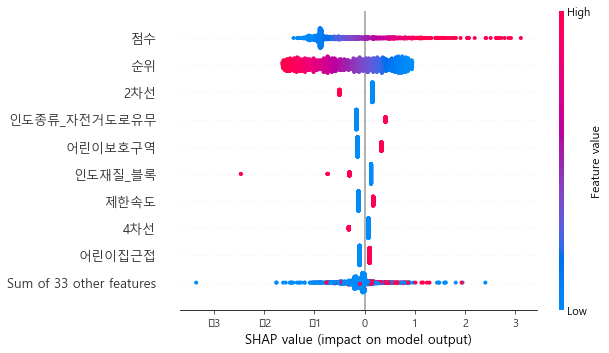

In [37]:
import shap
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font', family='Malgun Gothic')

explainer = shap.Explainer(model, x_resampled, feature_names=x_resampled.columns)
shap_values = explainer(x_test)
shap.plots.beeswarm(shap_values)

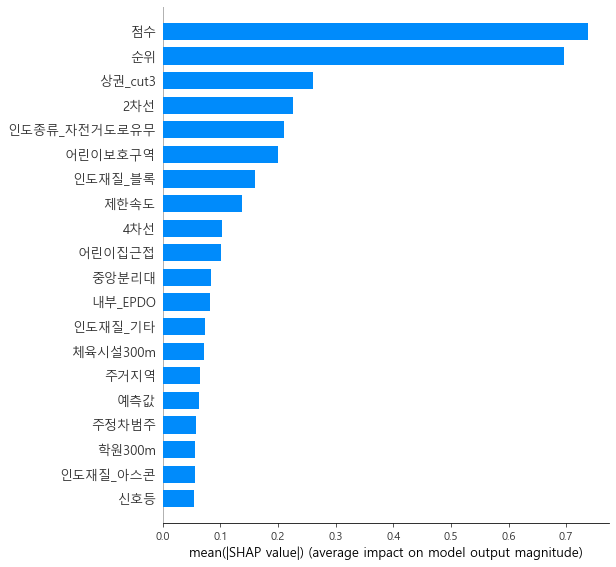

In [39]:
shap.summary_plot(shap_values, x_test, plot_type = "bar")

### (6) 원본 데이터셋으로 모델 실행

In [41]:
pred_y = model.predict(df_X)
get_clf_eval(df_Y, pred_y)
data['예측값'] = pred_y

오차행렬:
 [[2852  701]
 [  60  284]]

정확도: 0.8047
정밀도: 0.2883
재현율: 0.8256
F1: 0.4274
AUC: 0.8141


# 4. 어린이 교통사고 위험지역 순위 도출

### (1) 점수 산정

In [42]:
reg_score = pd.DataFrame(x_resampled.columns, columns=['feature'])
reg_score['coef'] = model.coef_[0]
reg_score

,feature,coef
0,const,-0.642536
1,주정차범주,0.136102
2,TMST_sum,-0.040444
3,초등학교,0.048153
4,어린이집근접,0.200706
5,무인교통단속카메라,0.177264
6,과속방지턱,0.028904
7,신호등,0.046206
8,cctv유무,-0.031247
9,인도재질_기타,0.261977


In [43]:
def cal(x):
    result = 0
    for f, c in zip(reg_score['feature'], reg_score['coef']):
        if f == 'const':
            result += c
        else:
            result += x[f]*c
    return result

data['점수'] = scaled_data.apply(cal, axis=1)

In [45]:
data['순위'] = data['점수'].rank(ascending=False)

In [46]:
data.sort_values('순위')

,gid,coordinates,accident,주정차범주,TMST_sum,초등학교,어린이집근접,무인교통단속카메라,과속방지턱,신호등,...,고원식,교통섬,상권_cut3,시설군,주거지역,내부_EPDO,예측값,점수,순위,어린이보호구역
3154,다사620064,"[[127.07204655572522, 37.15555938172145], [127...",1,0,223.476042,0,0,0,0,9,...,0.0,1.0,0,1,0,7.310764,1,7.678536,1.0,1
2472,다사610085,"[[127.06067537153925, 37.17444739853778], [127...",1,0,62.368936,0,0,0,0,4,...,0.0,0.0,0,0,0,12.666667,1,7.190310,2.0,0
2182,다사606089,"[[127.05614850831942, 37.178036163511216], [12...",1,0,94.210417,0,0,0,0,3,...,0.0,0.0,0,3,0,11.080357,1,7.149917,3.0,0
3191,다사621056,"[[127.0732132503874, 37.148352284891054], [127...",1,1,736.561042,0,1,0,0,7,...,0.0,0.0,1,19,1,7.657545,1,7.000849,4.0,0
3347,다사625043,"[[127.07778261954464, 37.13665026091001], [127...",1,1,59.243617,0,1,0,0,6,...,0.0,0.0,0,19,1,10.495098,1,6.908108,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,다사585102,"[[127.0324199187476, 37.189663191357404], [127...",0,0,185.402917,0,1,0,0,0,...,0.0,0.0,0,7,1,0.000000,0,-3.392994,3893.0,0
737,다사585103,"[[127.03241436083476, 37.19056457526543], [127...",0,0,233.860851,0,1,0,0,0,...,0.0,0.0,0,4,1,0.000000,0,-3.417394,3894.0,0
671,다사584102,"[[127.03129325409923, 37.18965873951206], [127...",0,0,115.797674,0,1,0,0,0,...,0.0,0.0,0,4,1,0.000000,0,-3.423408,3895.0,0
738,다사585104,"[[127.03240880267454, 37.191465959035256], [12...",0,0,98.037500,0,1,0,0,0,...,0.0,0.0,0,1,1,0.000000,0,-3.447900,3896.0,0
